In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from collections import OrderedDict
import sys
import os
import numpy as np
import json
import scipy.io
from pyDOE import lhs
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
sys.path.insert(0, '/home/deepview/Workspace/XiaoY/PINNs-TF2.0/PINNs/Utilities/')
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
import torch_rbf as rbf

In [2]:
np.random.seed(1234)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
class DNN(nn.Module):
    def __init__(self, layers, basis_func):
        super(DNN, self).__init__()
        self.layers = layers
        self.layer1 = rbf.RBF(layers[0], layers[1], basis_func)
        self.layer2 = nn.Linear(layers[1], layers[2])
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [4]:
class RBFNN(DNN):
    def __init__(self, X_u, u, layers, X_f, lb, ub, nu, basis_func):
        super(RBFNN, self).__init__(layers, basis_func)
        #初始化数据
        self.nu = nu
        self.u = torch.tensor(u).float().to(device)
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad = True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad = True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad = True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad = True).float().to(device)
        self.dnn = DNN(layers, basis_func).to(device)
        #将epoch初始化
        self.epoch = 0
        #设置LBFGS优化器，学习率为1，最大训练次数为5w次，终止梯度差1e-5
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       
        )

        #定义u（x，t）
    def u_model(self, x, t):
        u = self.dnn(torch.cat([x, t], dim = 1))
        return u
    
        #定义f（x，t）
    def f_model(self, x, t):
        u = self.u_model(x, t)
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        #此时u_x为一个列表（或者说计算图），所以在末尾加上[0]，得到tensor
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        f = u_t + u * u_x - self.nu * u_xx
        return f

        #定义损失函数
    def loss_fun(self):
        self.optimizer.zero_grad()
        loss_u = torch.mean((self.u_model(self.x_u, self.t_u) - self.u)**2)
        loss_f = torch.mean((self.f_model(self.x_f, self.t_f)) **2)
        loss = loss_u + loss_f
        #反向传播
        loss.backward()

        self.epoch += 1
        #每一百次迭代输出损失函数的值
        if self.epoch % 100 ==0:
            print('Epoch:{}, loss_u:{:5e}, loss_f:{:5e}, loss:{:5e}'.\
                format(self.epoch, loss_u.item(), loss_f.item(), loss.item()))
        
        return loss

        #训练函数
    def train(self):
        #self.dnn.train()
        self.optimizer.step(self.loss_fun)

        #模型预测
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad = True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad = True).float().to(device)
        self.dnn.eval()

        u = self.u_model(x, t)
        f = self.f_model(x, t)
        #detach(),阻断反向传播；cpu（）将数据放到cpu上；numpy（）将Tensor转化为numpy
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()

        return u,f


    def predict_x(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad = True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad = True).float().to(device)
        self.dnn.eval()

        u = self.u_model(x, t)
        f = self.f_model(x, t)
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        #detach(),阻断反向传播；cpu（）将数据放到cpu上；numpy（）将Tensor转化为numpy
        u_x = u_x.detach().cpu().numpy()
        f = f.detach().cpu().numpy()

        return u_x, f

In [5]:
#数据处理，基本摘抄原作者TensorFlow版
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000
layers = [2, 20, 1]

data = scipy.io.loadmat('/home/deepview/Workspace/XiaoY/PINNs-TF2.0/1d-burgers/data\
/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              
# 边界点
lb = X_star.min(0)
ub = X_star.max(0) 

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]
#边界点
X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
#内点+边界点
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])
#随机选择N_u个边界点
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]
basis_func = rbf.inverse_multiquadric

In [6]:
model = RBFNN(X_u_train, u_train, layers, X_f_train, lb, ub, nu, basis_func)

In [7]:
%%time
               
#开始训练
model.train()

Epoch:100, loss_u:4.614829e-02, loss_f:2.392126e-02, loss:7.006955e-02
Epoch:200, loss_u:4.119349e-02, loss_f:2.150328e-02, loss:6.269678e-02
Epoch:300, loss_u:4.018159e-02, loss_f:2.032940e-02, loss:6.051099e-02
Epoch:400, loss_u:4.012493e-02, loss_f:1.989207e-02, loss:6.001700e-02
Epoch:500, loss_u:3.999256e-02, loss_f:1.951793e-02, loss:5.951049e-02
Epoch:600, loss_u:4.055582e-02, loss_f:1.870199e-02, loss:5.925781e-02
Epoch:700, loss_u:3.996801e-02, loss_f:1.891541e-02, loss:5.888342e-02
Epoch:800, loss_u:3.994188e-02, loss_f:1.878628e-02, loss:5.872816e-02
Epoch:900, loss_u:3.748585e-02, loss_f:1.921844e-02, loss:5.670429e-02
Epoch:1000, loss_u:3.737427e-02, loss_f:1.795026e-02, loss:5.532453e-02
Epoch:1100, loss_u:3.760491e-02, loss_f:1.715100e-02, loss:5.475591e-02
Epoch:1200, loss_u:3.737642e-02, loss_f:1.709767e-02, loss:5.447409e-02
Epoch:1300, loss_u:3.731716e-02, loss_f:1.684764e-02, loss:5.416480e-02
Epoch:1400, loss_u:3.706230e-02, loss_f:1.698496e-02, loss:5.404726e-02
E

In [8]:
#获得预测值
u_pred, f_pred = model.predict(X_star)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
#输出误差
print('Error u: %e' % (error_u))                     
#对预测值进行插值
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 5.103995e-01


In [9]:
print(dict(model.named_parameters()))

{'layer1.centres': Parameter containing:
tensor([[ 0.4382,  0.9587],
        [-1.5713, -0.1567],
        [-0.9296,  0.0864],
        [ 1.4701,  0.8583],
        [-0.3413, -0.7274],
        [-0.6062,  2.1951],
        [-0.4144,  0.4831],
        [-0.5454, -0.2871],
        [ 0.0255,  1.0883],
        [-1.5545, -1.2165],
        [-1.2331,  0.6097],
        [-0.3794,  1.0504],
        [-1.7096,  1.4041],
        [ 1.6402, -0.1580],
        [-1.1248,  0.2306],
        [-1.0010,  0.4814],
        [-0.7375, -1.1388],
        [-1.4366,  1.5728],
        [-0.9357, -0.2421],
        [-1.8420,  0.3526]], requires_grad=True), 'layer1.sigmas': Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], requires_grad=True), 'layer2.weight': Parameter containing:
tensor([[-0.1734,  0.0750,  0.1644,  0.0192, -0.1109, -0.0512,  0.1244,  0.1330,
         -0.1777, -0.0715,  0.1479,  0.1607,  0.0255, -0.1871, -0.1267, -0.1804,
         -0.1307,  

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


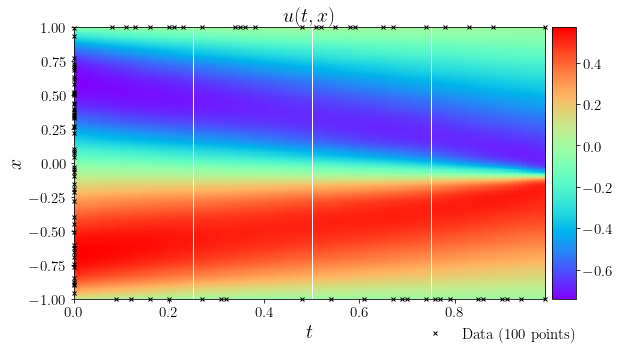

In [10]:
#画图，基本摘抄原作者TensorFlow版
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) 
ax.tick_params(labelsize=15)
plt.savefig('PINNs.eps')
plt.show()

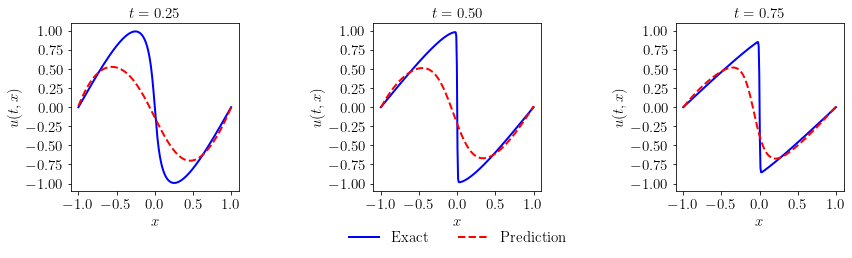

In [11]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()